# PC Pacific Grid Exploration

## Imports and Functions

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from sklearn.preprocessing import MinMaxScaler
import scipy as sp
import os
from matplotlib.colors import ListedColormap, BoundaryNorm

import sys
import seaborn as sns

In [2]:
# Add the folder to the Python path

os.chdir("../")
# change working directory to project's root path
print(os.getcwd())

folder_path = os.path.abspath("functions/") #INPUT_PATH)#'path_to_your_folder')  # Replace with the actual folder path
sys.path.insert(0, folder_path)

c:\Users\marti\Desktop\data\hw_extra


In [3]:

from IndexDrivers import (
    MultivariatePCA, 
    plot_hw_index,
    plot_hw_index_by_season,
    scatter_color_year,
    scatter_color_season
)

In [4]:
def df_to_series(dataframe, name_series, years=[1979,2023]):
    selected = dataframe[(dataframe["Year"]< years[1]) & (dataframe["Year"] > years[0])]
    df_melted = selected.melt(id_vars=['Year'], var_name='Month', value_name=name_series)
    df_melted["Month"] = pd.to_numeric(df_melted["Month"])
    df_melted = df_melted.sort_values(['Year','Month'])

    df_melted['Date'] = pd.to_datetime(df_melted[['Year', 'Month']].assign(DAY=1))
    df_melted.set_index('Date', inplace=True)

    return df_melted.drop(columns=["Year", "Month"])

def plot_corr(dataframe, cols):
    sns.heatmap(dataframe.corr()[cols], cmap="coolwarm", annot=True)
    plt.show()

In [5]:
ds_5means = xr.load_dataset("data/local_data/5means_world.nc")

## PCA on separated boxes

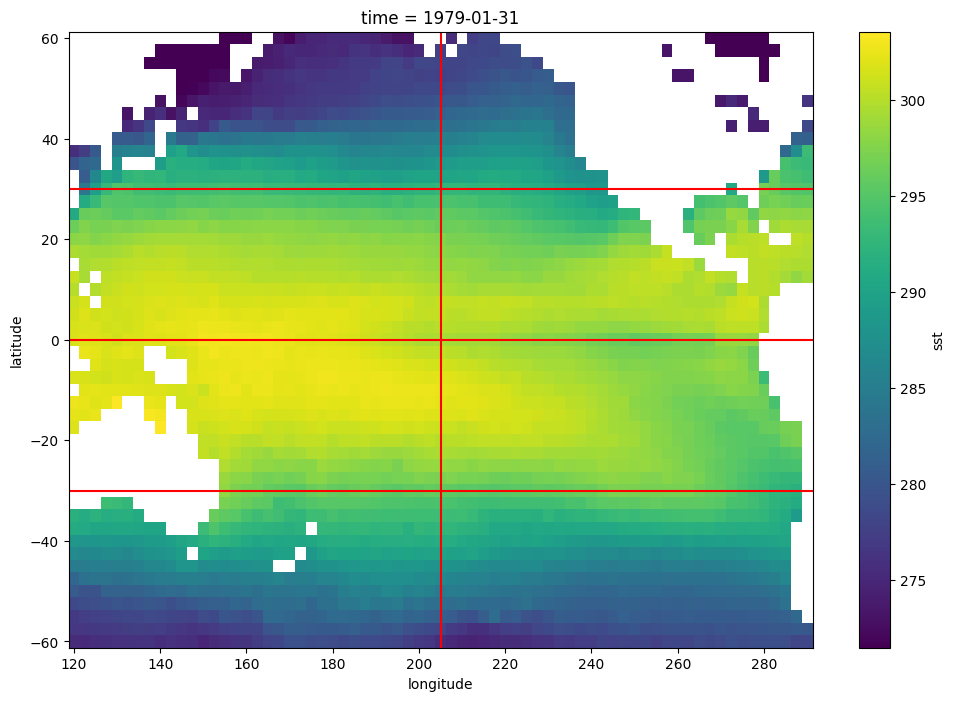

In [6]:
fig, axs = plt.subplots(figsize=(12,8))
ds_5means.sel(latitude=slice(-60,60), longitude=slice(120,290)).sst.isel(time=0).plot(ax=axs)
for i in range(3):
    axs.axhline(-30+i*30, c="red")
axs.axvline(205, c="red")
plt.show()

In [7]:
boxes = {
    0: [120,205,30,60],
    1: [205,290,30,60],
    2: [120,205,0,30],
    3: [205,290,0,30],
    4: [120,205,-30,0],
    5: [205,290,-30,0],
    6: [120,205,-60,-30],
    7: [205,290,-60,-30]
}

In [8]:
grid_pca = {}
for num, box in boxes.items():
    grid_pca[num] = MultivariatePCA(ds_5means, 2, [1980,2022], box_limit=box)
    

In [27]:
hwis = pd.read_csv("data/local_data/HWs_330020.csv")
hwis["Date"] = pd.to_datetime(hwis["Date"],format='%Y-%m')
hwis.set_index('Date', inplace=True)

hwis = hwis[(hwis.index.year <= 2022) & (hwis.index.year >= 1980)]
for mode in range(grid_pca[0].n_modes):
    for num, pca in grid_pca.items():
        hwis[f"Box {num}-Mode {mode+1}"] = pca.get_index(mode+1, start_year=1980)

Lets plot the correlation betwween the indices and the modes for the full span time

In [32]:
corr = hwis.corr()[["HWN", "HWF", "HWD", "HWM", "HWA"]]
corr.style.background_gradient(cmap='coolwarm').format("{:.3f}")

,HWN,HWF,HWD,HWM,HWA
HWN,1.000,0.957,0.884,0.784,0.853
HWF,0.957,1.000,0.929,0.747,0.831
HWD,0.884,0.929,1.000,0.821,0.872
HWM,0.784,0.747,0.821,1.000,0.969
HWA,0.853,0.831,0.872,0.969,1.000
Box 0-Mode 1,-0.003,0.002,0.018,0.027,0.026
Box 1-Mode 1,-0.038,-0.041,-0.042,-0.031,-0.031
Box 2-Mode 1,0.030,0.022,-0.003,-0.015,0.002
Box 3-Mode 1,0.051,0.057,0.068,0.105,0.093
Box 4-Mode 1,0.063,0.056,0.053,0.091,0.081


We can check the correlation separated by biseason now, it appears to increase in certain boxes/seasons.

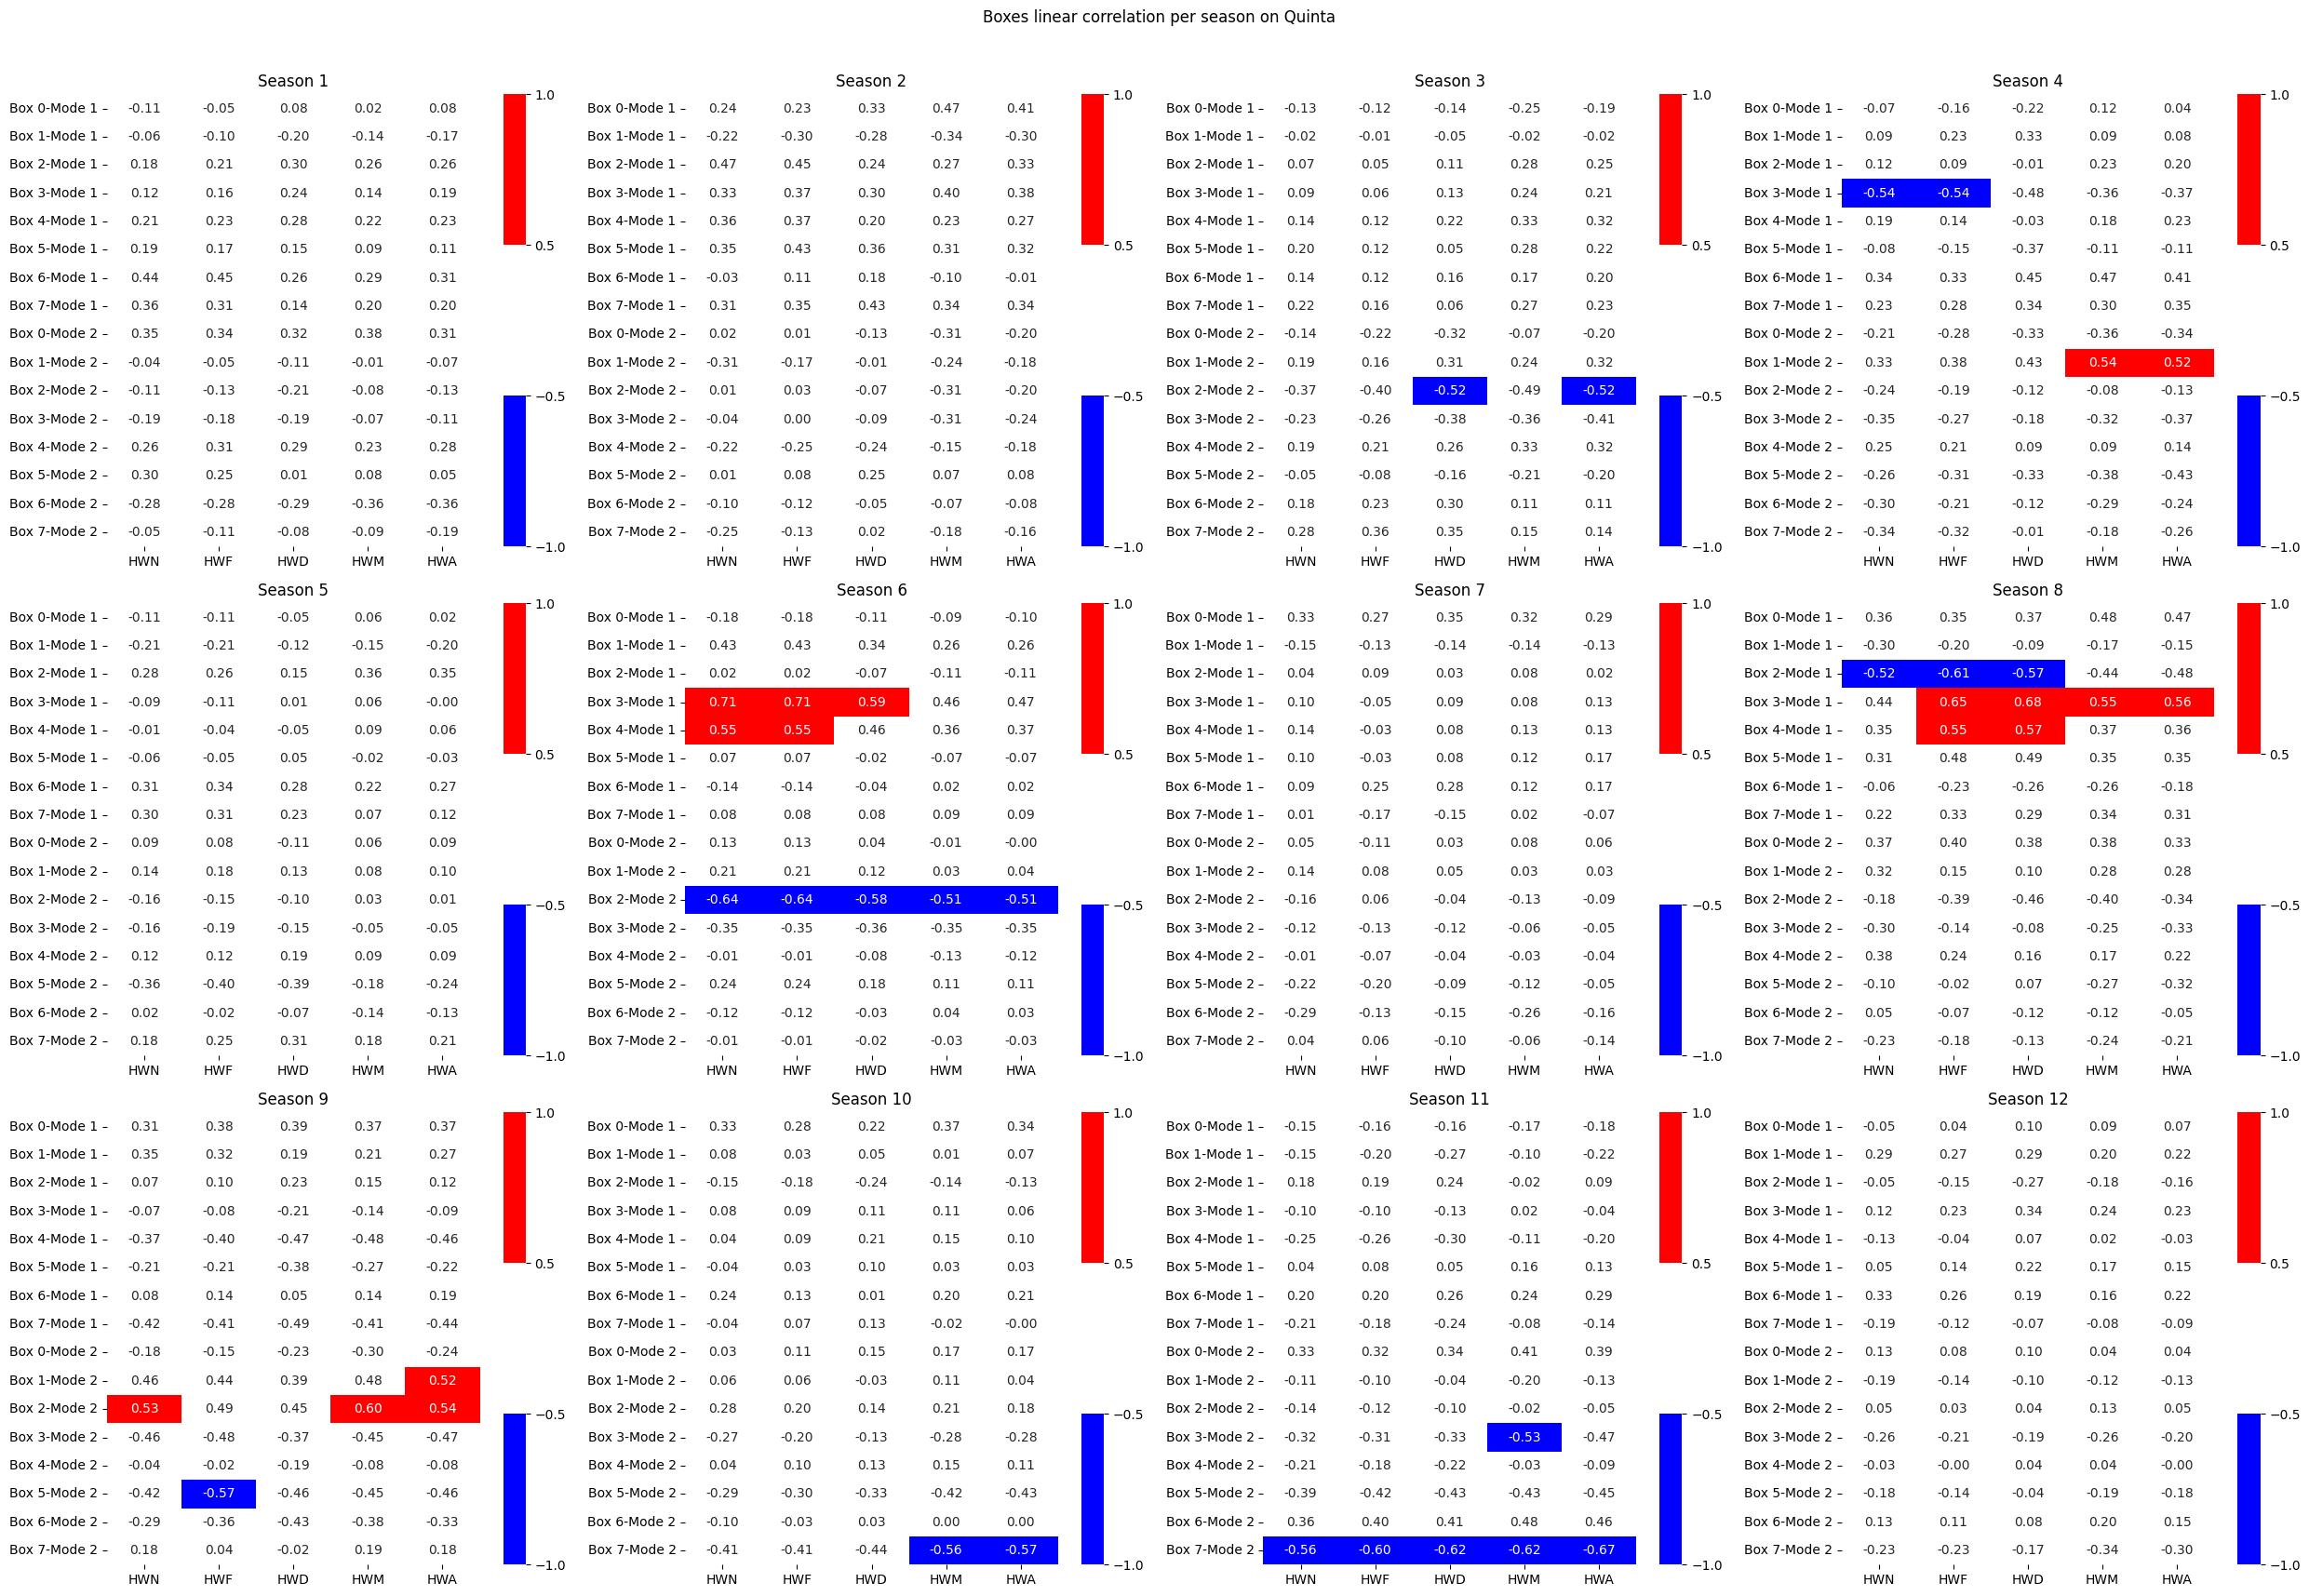

In [39]:
fig, axs = plt.subplots(3,4, figsize=(25,18))

hwis = hwis[(hwis.index.year <= 2022) & (hwis.index.year >= 2000)]
colors = ["blue", "white", "red"]
cmap = ListedColormap(colors)

# Define boundaries and normalize color range
bounds = [-1, -0.5, 0.5, 1]
norm = BoundaryNorm(bounds, cmap.N)


for i in range(12):
    hwis_month = hwis[hwis.index.month==i+1]
    for num, pca in grid_pca.items():
        hwis_month.loc[:, f"Box {num}-Mode 1"] = pca.get_index_by_season(i+1, 1, start_year=2000)
    sns.heatmap(hwis_month.corr(method='pearson')[["HWN", "HWF", "HWD", "HWM", "HWA"]][5:], annot=True, fmt=".2f", cmap=cmap, norm=norm, ax=axs.flatten()[i], vmax=1, vmin=-1)
    axs.flatten()[i].set_title(f"Season {i+1}")
fig.tight_layout(rect=[0, 0.03, 1, 0.95])  # otherwise the right y-label is slightly clipped
fig.suptitle(f"Boxes linear correlation per season on Quinta")
plt.show()

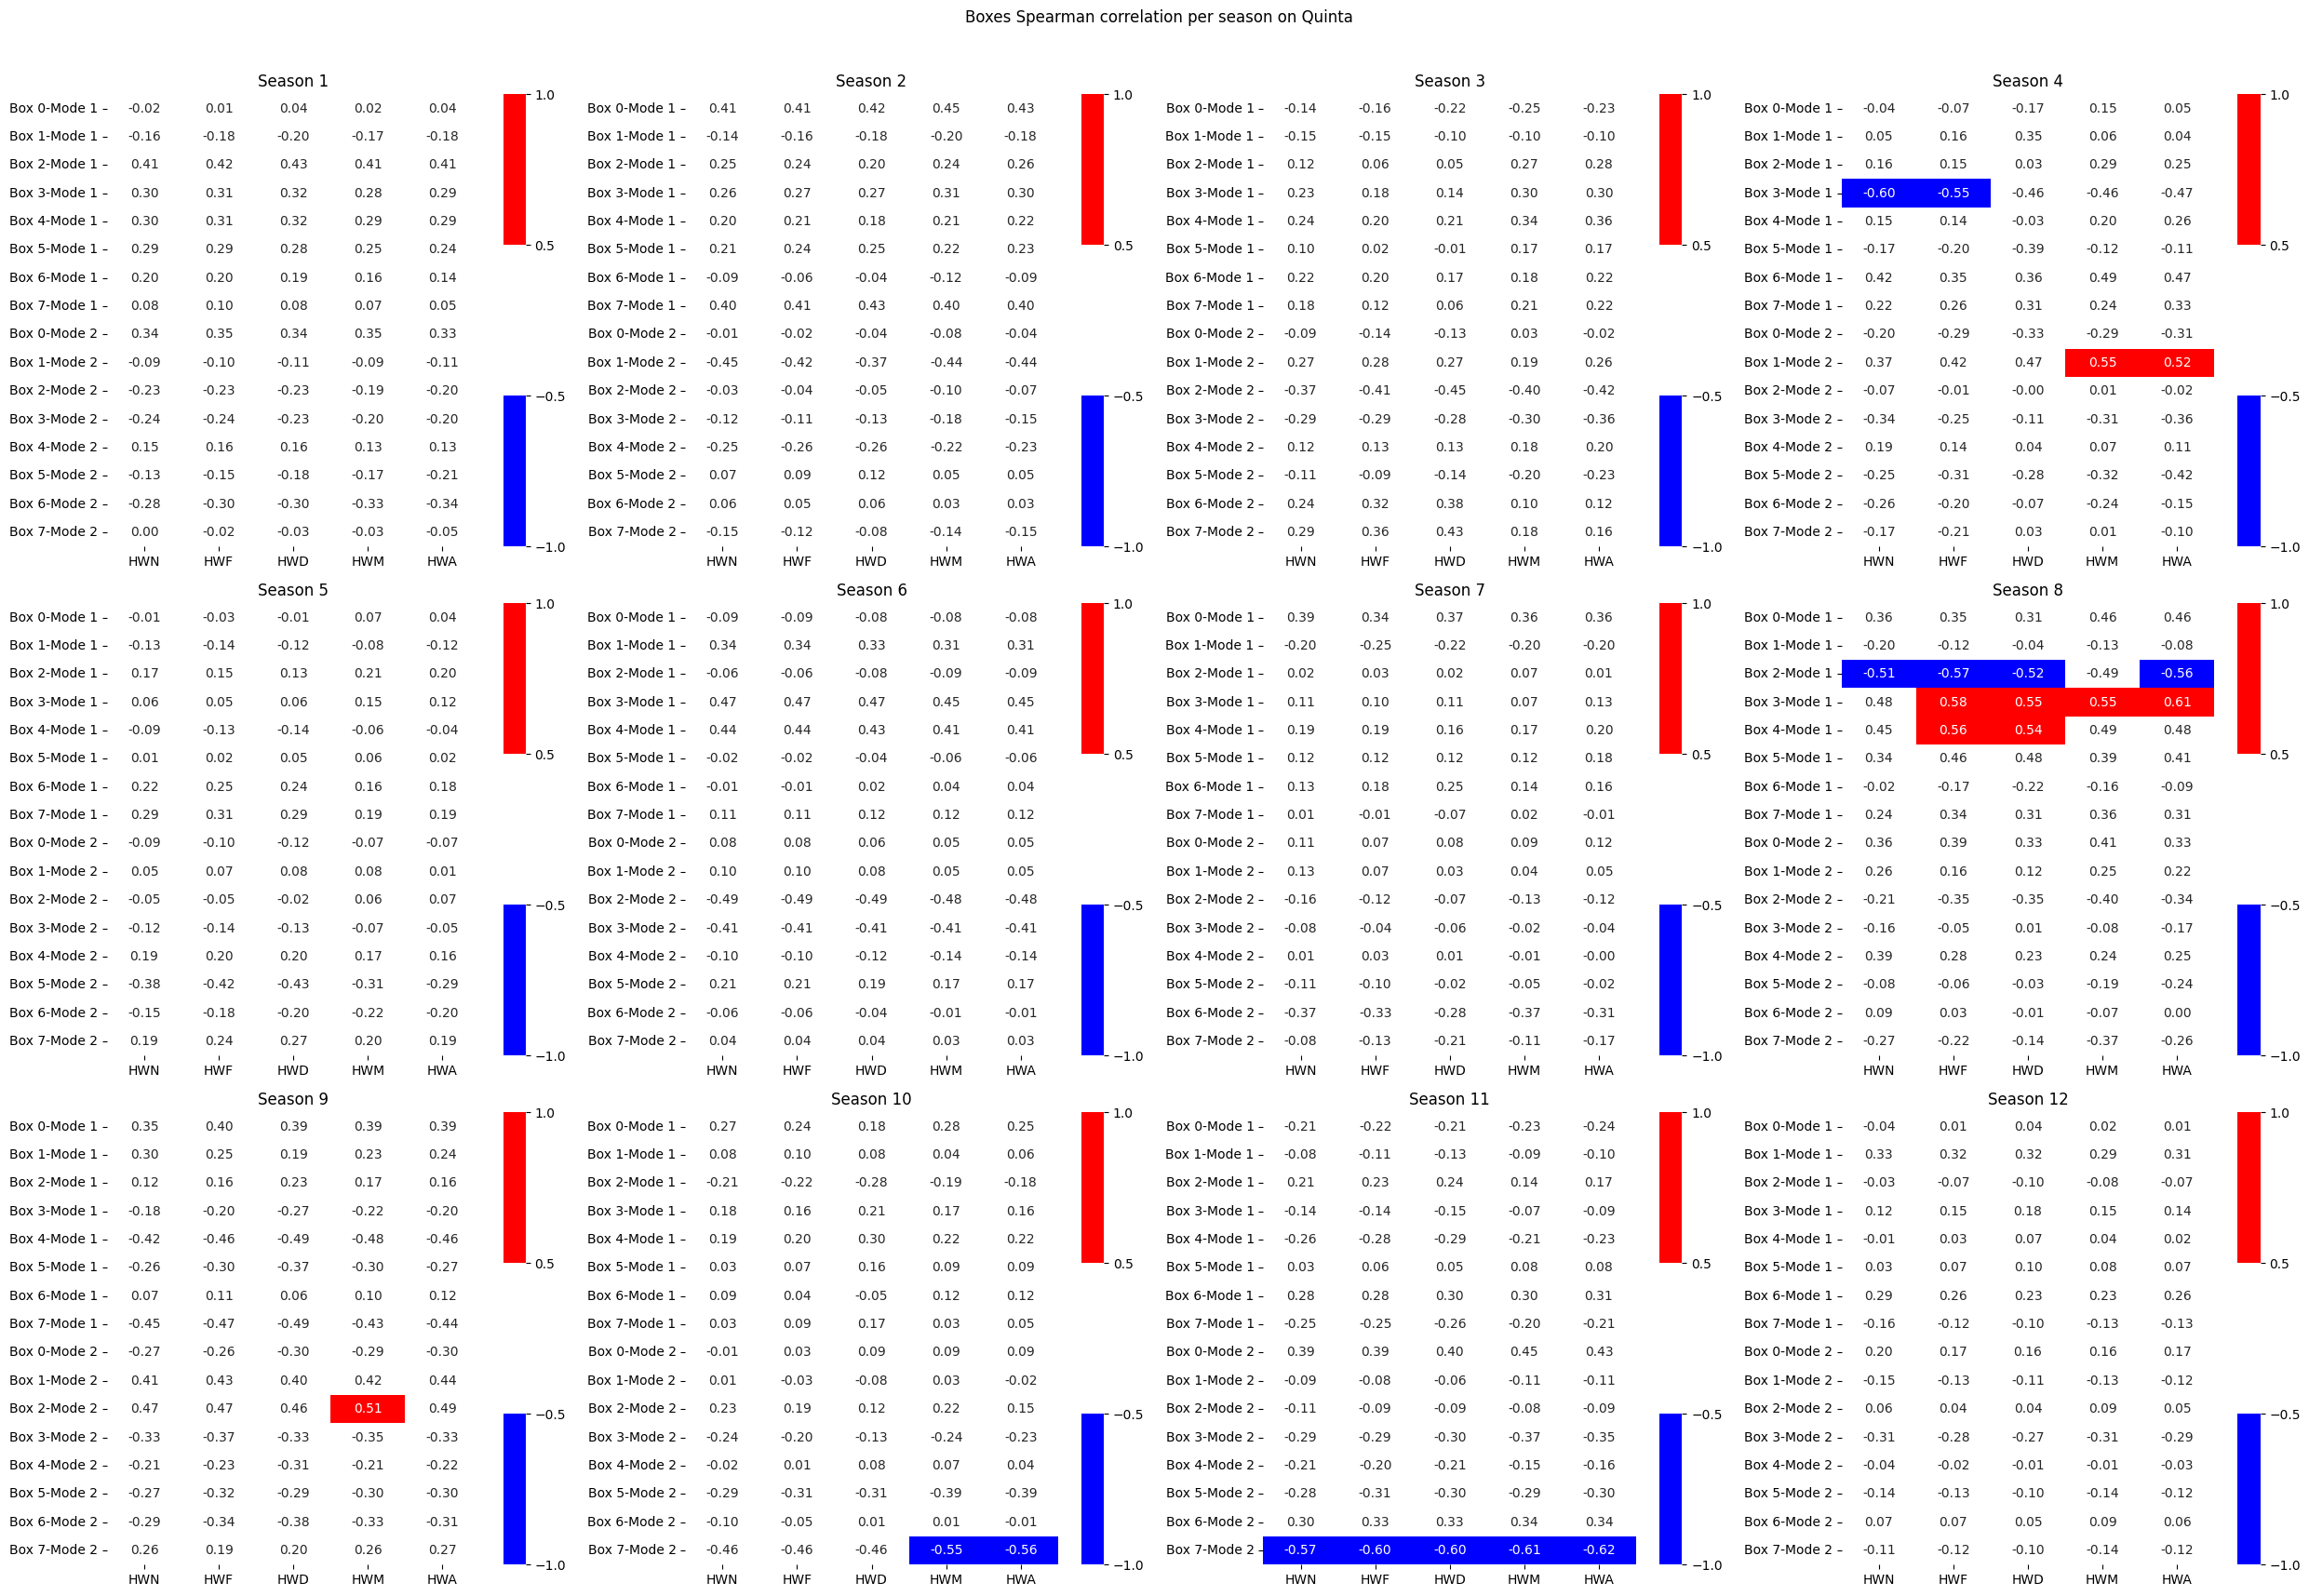

In [40]:
fig, axs = plt.subplots(3,4, figsize=(25,18))

hwis = hwis[(hwis.index.year <= 2022) & (hwis.index.year >= 2000)]
colors = ["blue", "white", "red"]
cmap = ListedColormap(colors)

# Define boundaries and normalize color range
bounds = [-1, -0.5, 0.5, 1]
norm = BoundaryNorm(bounds, cmap.N)


for i in range(12):
    hwis_month = hwis[hwis.index.month==i+1]
    for num, pca in grid_pca.items():
        hwis_month.loc[:, f"Box {num}-Mode 1"] = pca.get_index_by_season(i+1, 1, start_year=2000)
    sns.heatmap(hwis_month.corr(method='spearman')[["HWN", "HWF", "HWD", "HWM", "HWA"]][5:], annot=True, fmt=".2f", cmap=cmap, norm=norm, ax=axs.flatten()[i], vmax=1, vmin=-1)
    axs.flatten()[i].set_title(f"Season {i+1}")
fig.tight_layout(rect=[0, 0.03, 1, 0.95])  # otherwise the right y-label is slightly clipped
fig.suptitle(f"Boxes Spearman correlation per season on Quinta")
plt.show()

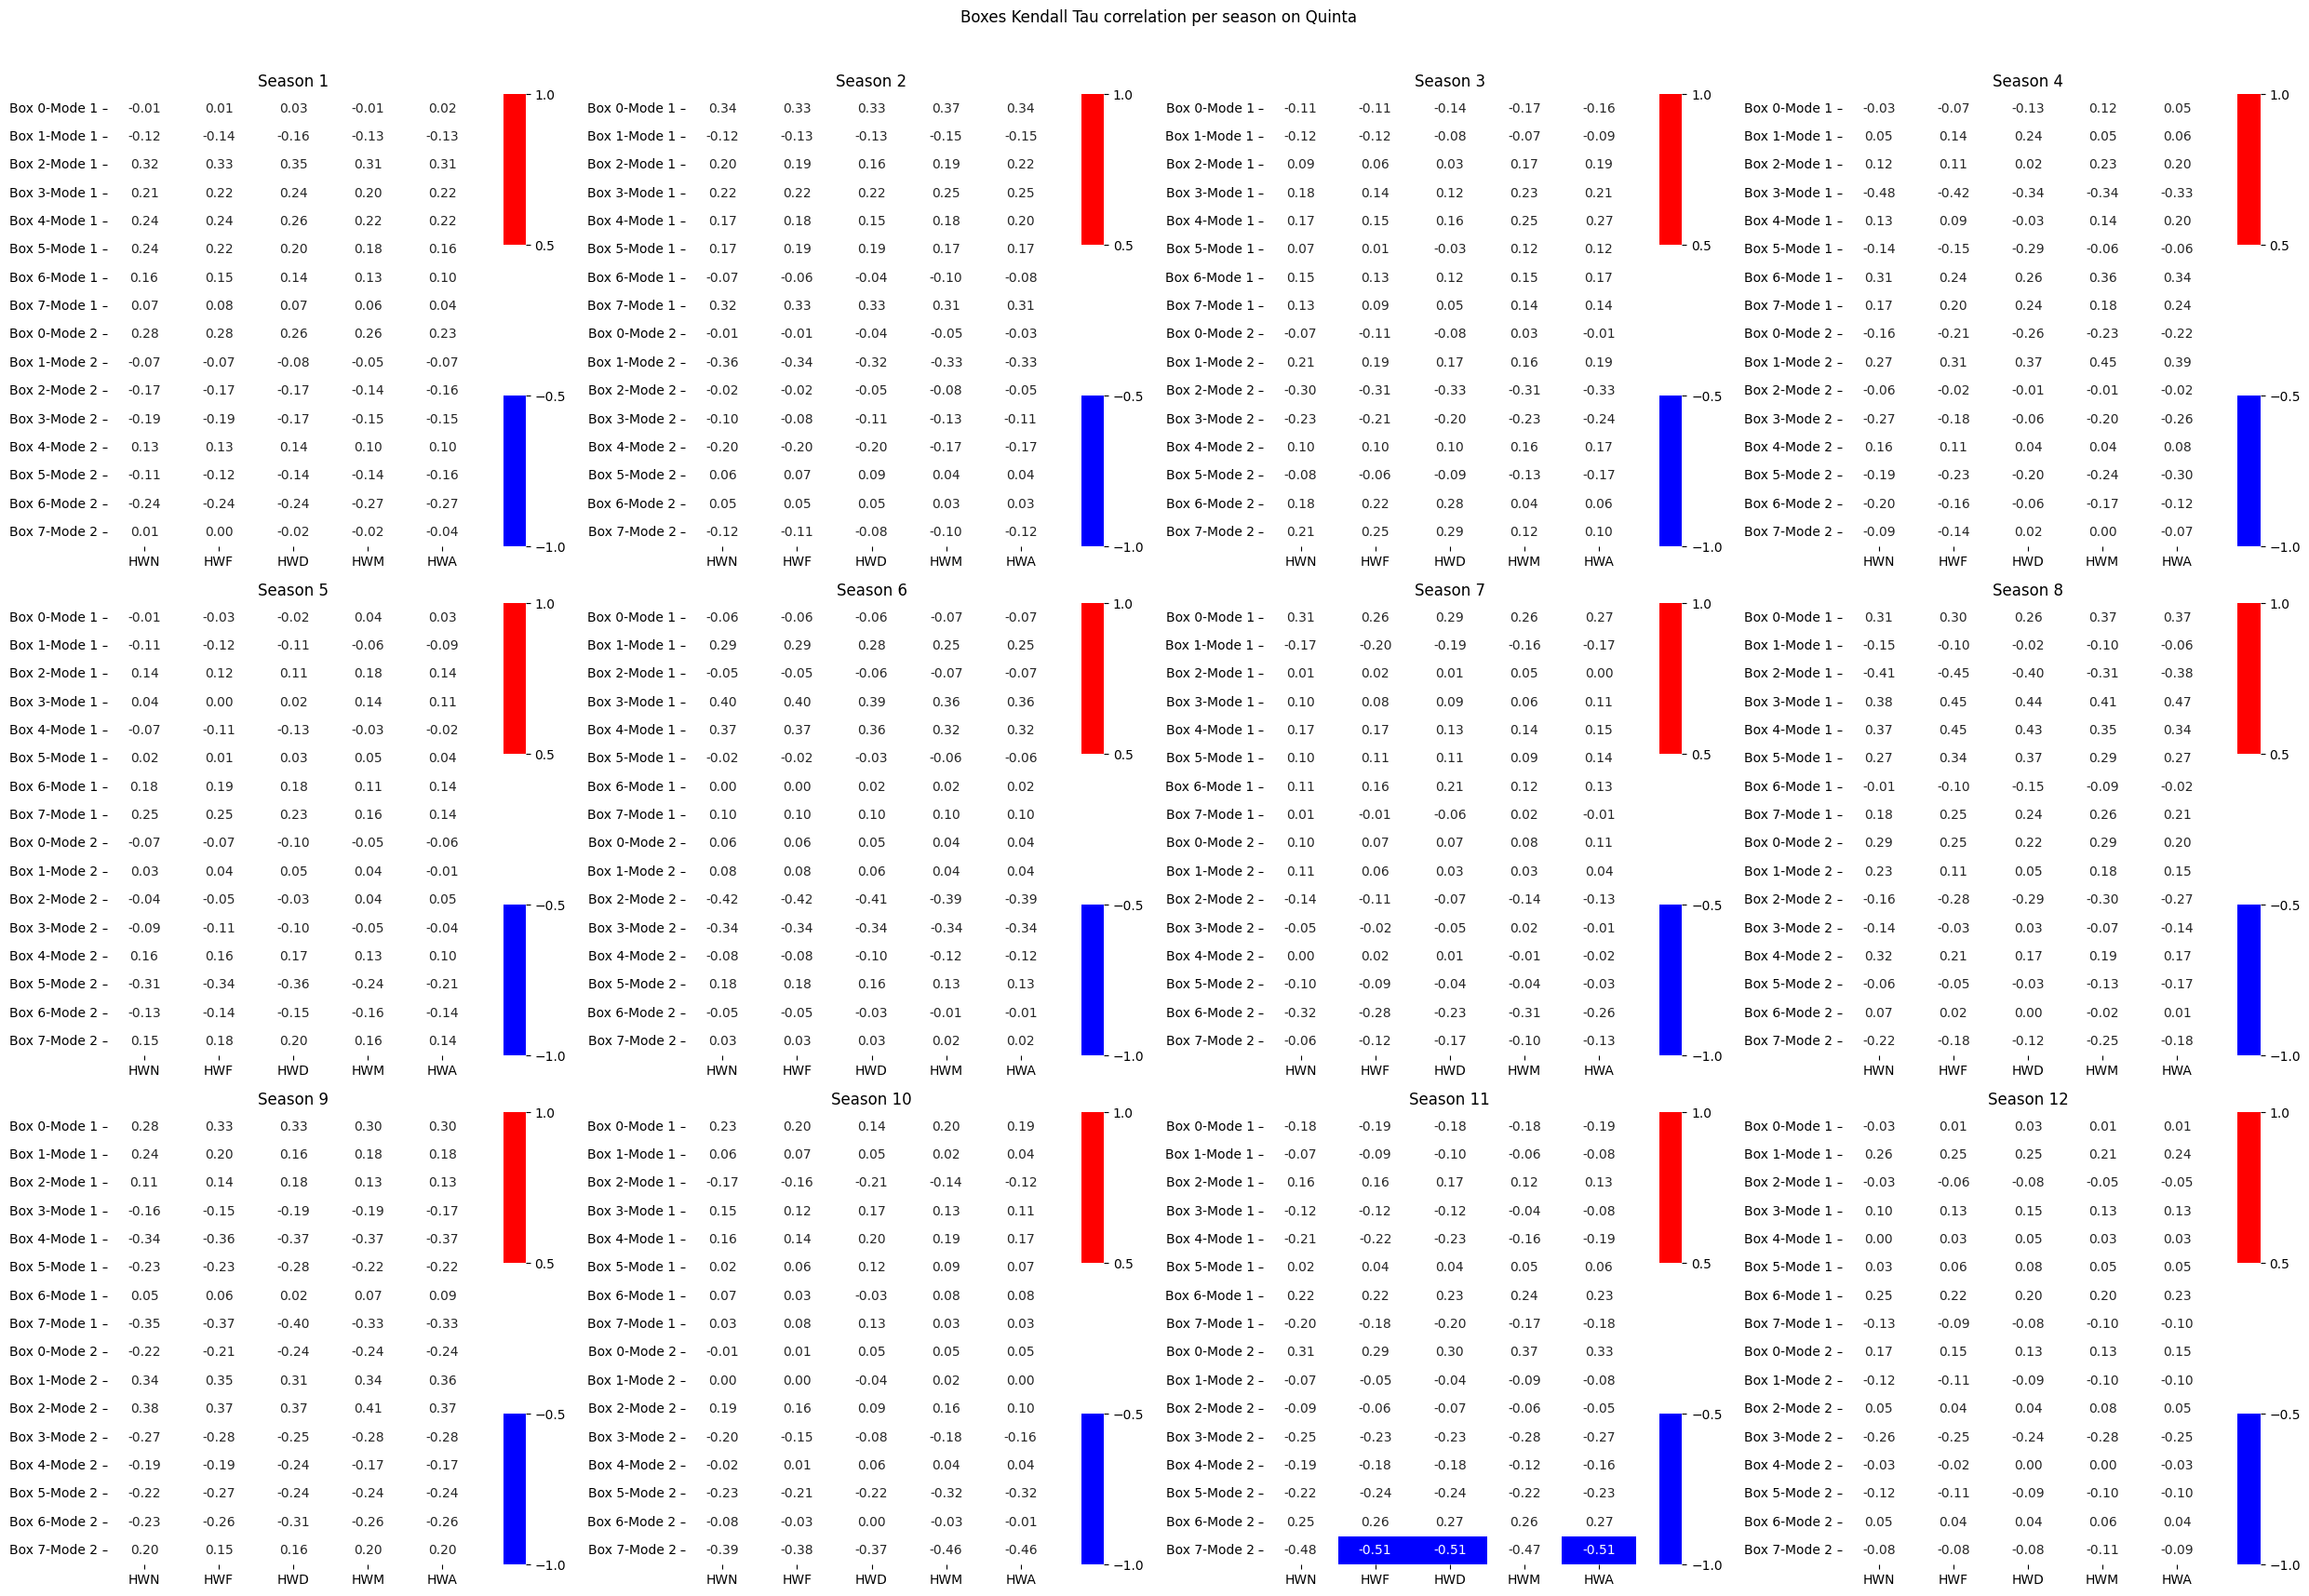

In [41]:
fig, axs = plt.subplots(3,4, figsize=(25,18))

hwis = hwis[(hwis.index.year <= 2022) & (hwis.index.year >= 2000)]
colors = ["blue", "white", "red"]
cmap = ListedColormap(colors)

# Define boundaries and normalize color range
bounds = [-1, -0.5, 0.5, 1]
norm = BoundaryNorm(bounds, cmap.N)


for i in range(12):
    hwis_month = hwis[hwis.index.month==i+1]
    for num, pca in grid_pca.items():
        hwis_month.loc[:, f"Box {num}-Mode 1"] = pca.get_index_by_season(i+1, 1, start_year=2000)
    sns.heatmap(hwis_month.corr(method='kendall')[["HWN", "HWF", "HWD", "HWM", "HWA"]][5:], annot=True, fmt=".2f", cmap=cmap, norm=norm, ax=axs.flatten()[i], vmax=1, vmin=-1)
    axs.flatten()[i].set_title(f"Season {i+1}")
fig.tight_layout(rect=[0, 0.03, 1, 0.95])  # otherwise the right y-label is slightly clipped
fig.suptitle(f"Boxes Kendall Tau correlation per season on Quinta")
plt.show()

A good question is about shifted correlation. As we want to predict the HW indices based on past data, let's check the 1-season shifted correlation:

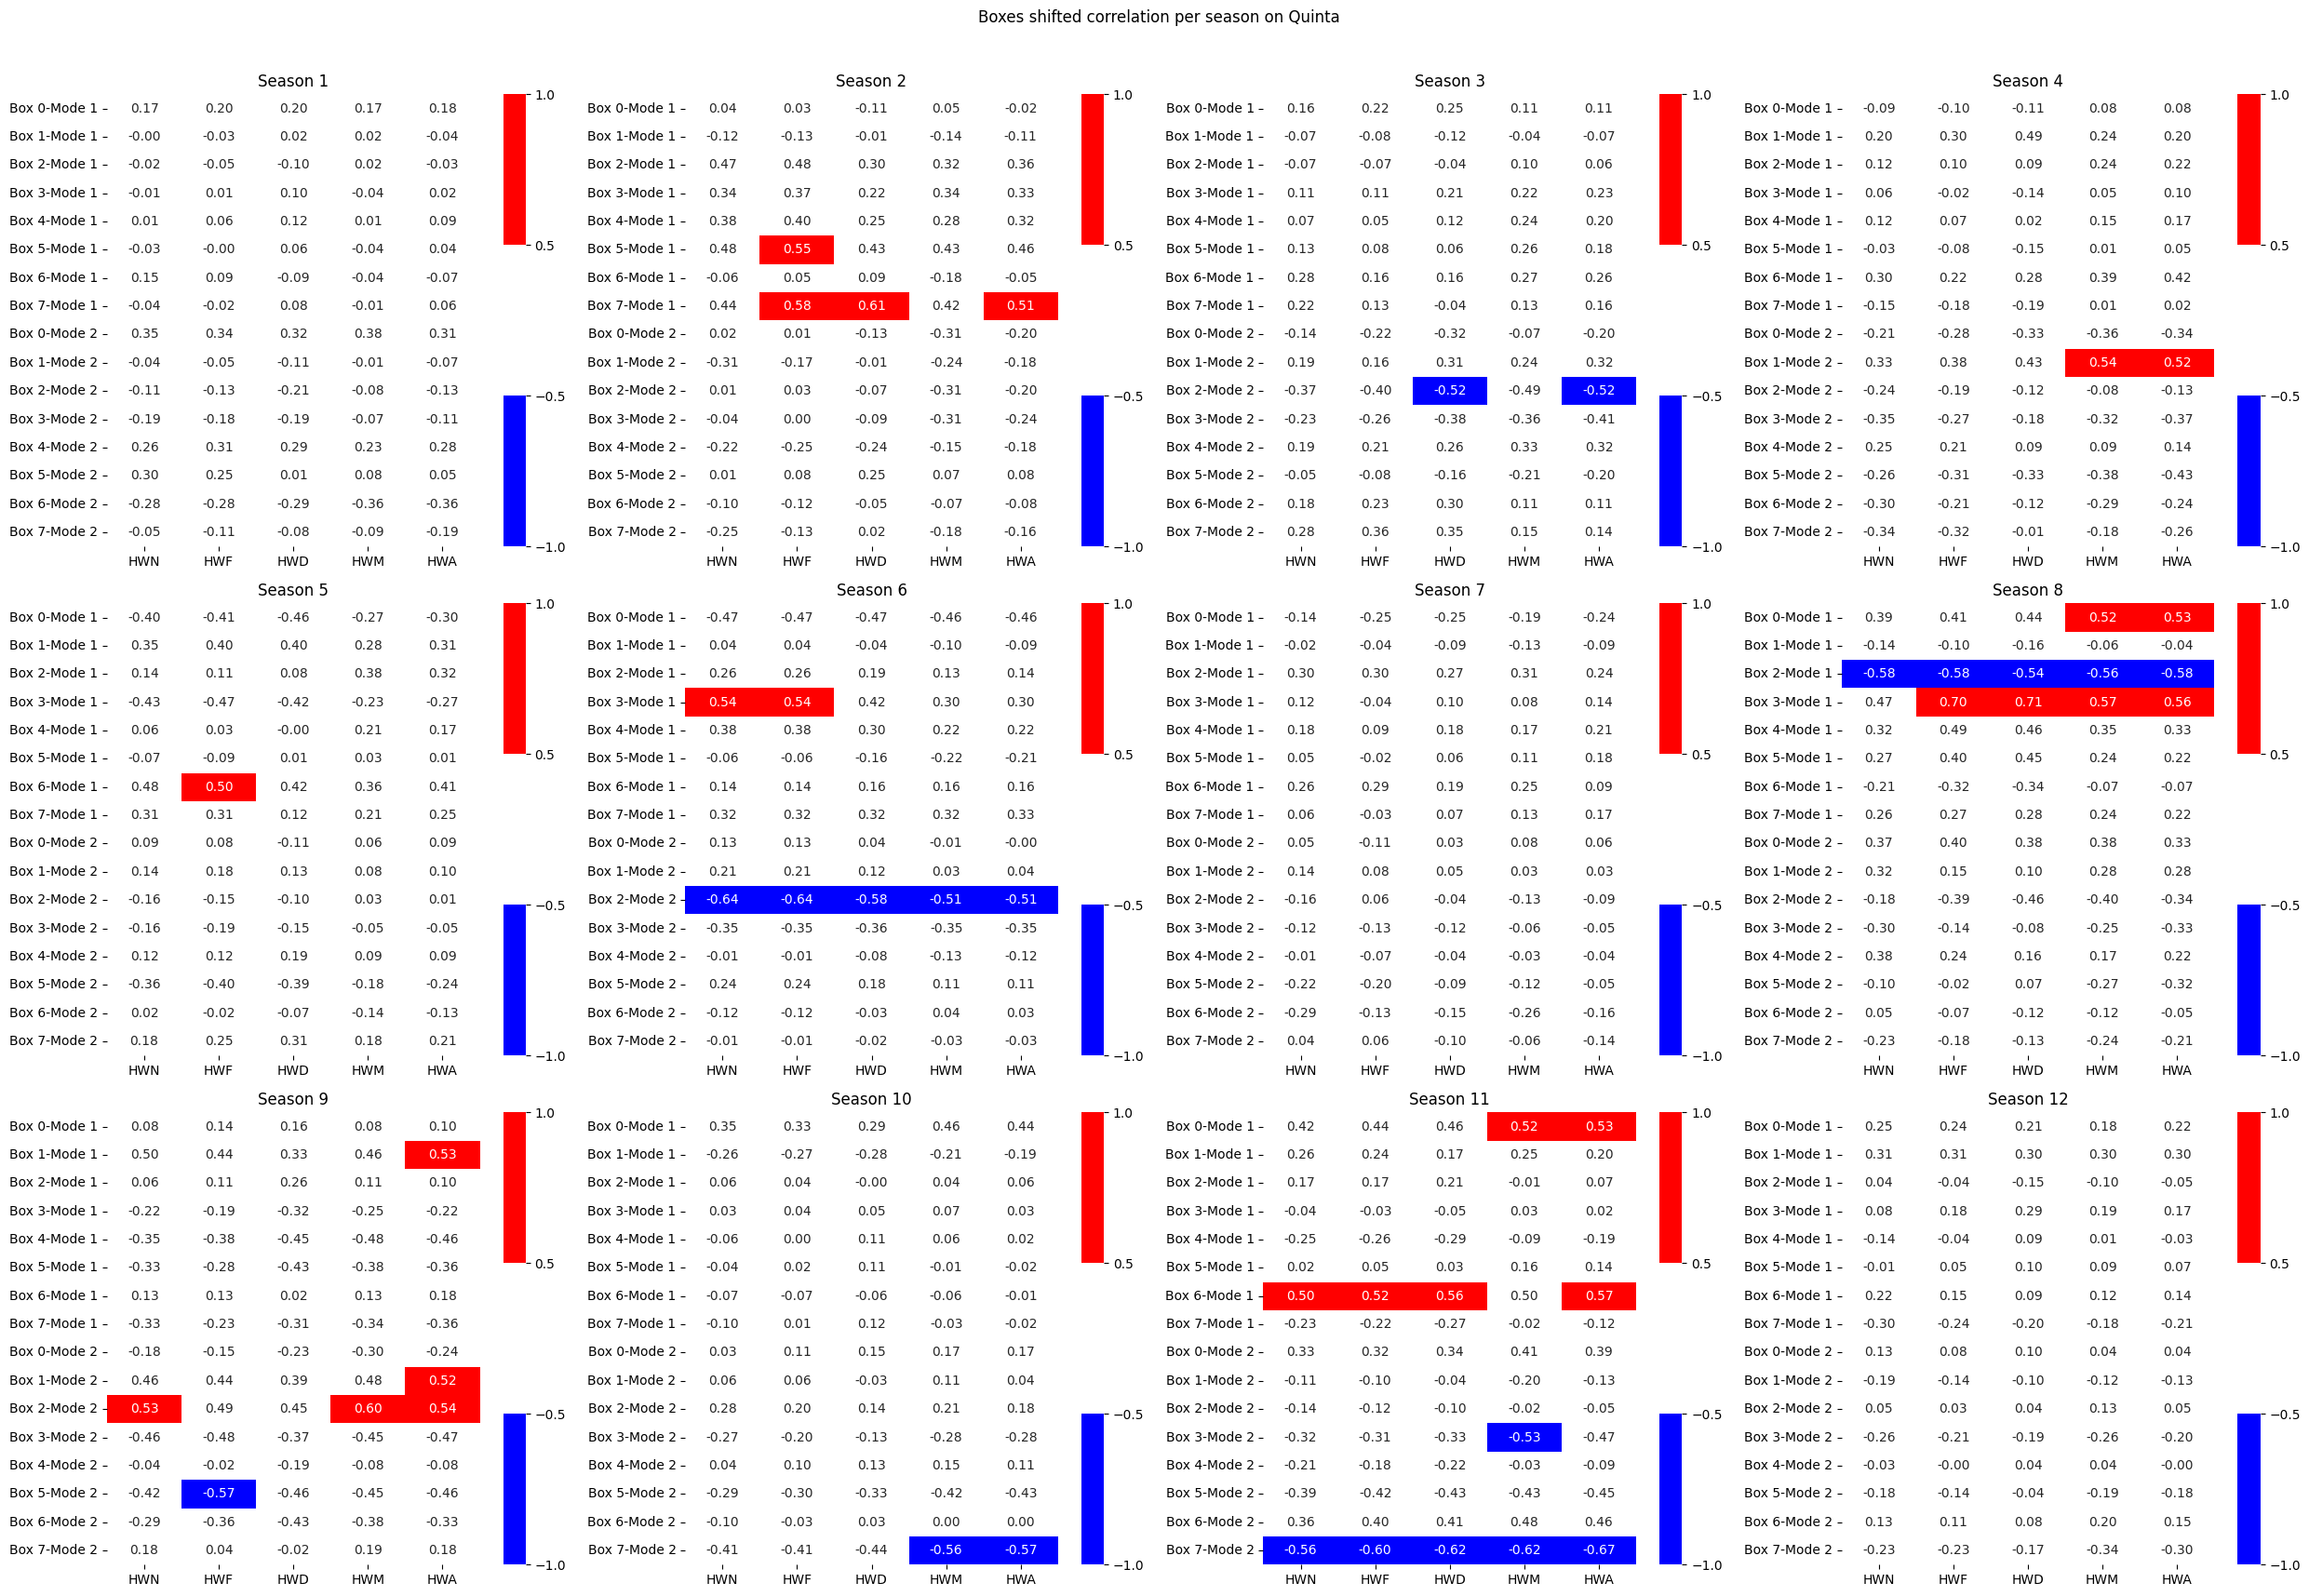

In [36]:
fig, axs = plt.subplots(3,4, figsize=(25,18))

hwis = hwis[(hwis.index.year <= 2022) & (hwis.index.year >= 2000)]
for i in range(12):
    hwis_month = hwis[hwis.index.month==i+1]
    for num, pca in grid_pca.items():
        if i!= 0:
            hwis_month.loc[:, f"Box {num}-Mode 1"] = pca.get_index_by_season(i, 1, start_year=2000)
        else:
            hwis_month.loc[:, f"Box {num}-Mode 1"] = pca.get_index_by_season(12, 1, start_year=2000)
    sns.heatmap(hwis_month.corr()[["HWN", "HWF", "HWD", "HWM", "HWA"]][5:], annot=True, fmt=".2f", cmap=cmap, norm=norm, ax=axs.flatten()[i], vmax=1, vmin=-1)
    axs.flatten()[i].set_title(f"Season {i+1}")
fig.tight_layout(rect=[0, 0.03, 1, 0.95])  # otherwise the right y-label is slightly clipped
fig.suptitle(f"Boxes shifted correlation per season on Quinta")
plt.show()

### California

In [42]:
hwis = pd.read_csv("data/local_data/HWs_47.csv")
hwis["Date"] = pd.to_datetime(hwis["Date"],format='%Y-%m')
hwis.set_index('Date', inplace=True)

hwis = hwis[(hwis.index.year <= 2022) & (hwis.index.year >= 1989)]
for mode in range(grid_pca[0].n_modes):
    for num, pca in grid_pca.items():
        hwis[f"Box {num}-Mode {mode+1}"] = pca.get_index(mode+1, start_year=1989)

Lets plot the correlation betwween the indices and the modes for the full span time

In [43]:
corr = hwis.corr()[["HWN", "HWF", "HWD", "HWM", "HWA"]]
corr.style.background_gradient(cmap='coolwarm').format("{:.3f}")

,HWN,HWF,HWD,HWM,HWA
HWN,1.000,0.909,0.802,0.684,0.805
HWF,0.909,1.000,0.939,0.687,0.813
HWD,0.802,0.939,1.000,0.739,0.829
HWM,0.684,0.687,0.739,1.000,0.962
HWA,0.805,0.813,0.829,0.962,1.000
Box 0-Mode 1,0.080,0.093,0.050,0.002,0.029
Box 1-Mode 1,0.034,0.038,0.046,0.064,0.043
Box 2-Mode 1,0.019,0.023,0.002,0.011,0.012
Box 3-Mode 1,0.005,0.019,-0.000,-0.055,-0.043
Box 4-Mode 1,-0.027,-0.013,-0.025,-0.089,-0.085


We can check the correlation separated by biseason now, it appears to increase in certain boxes/seasons.

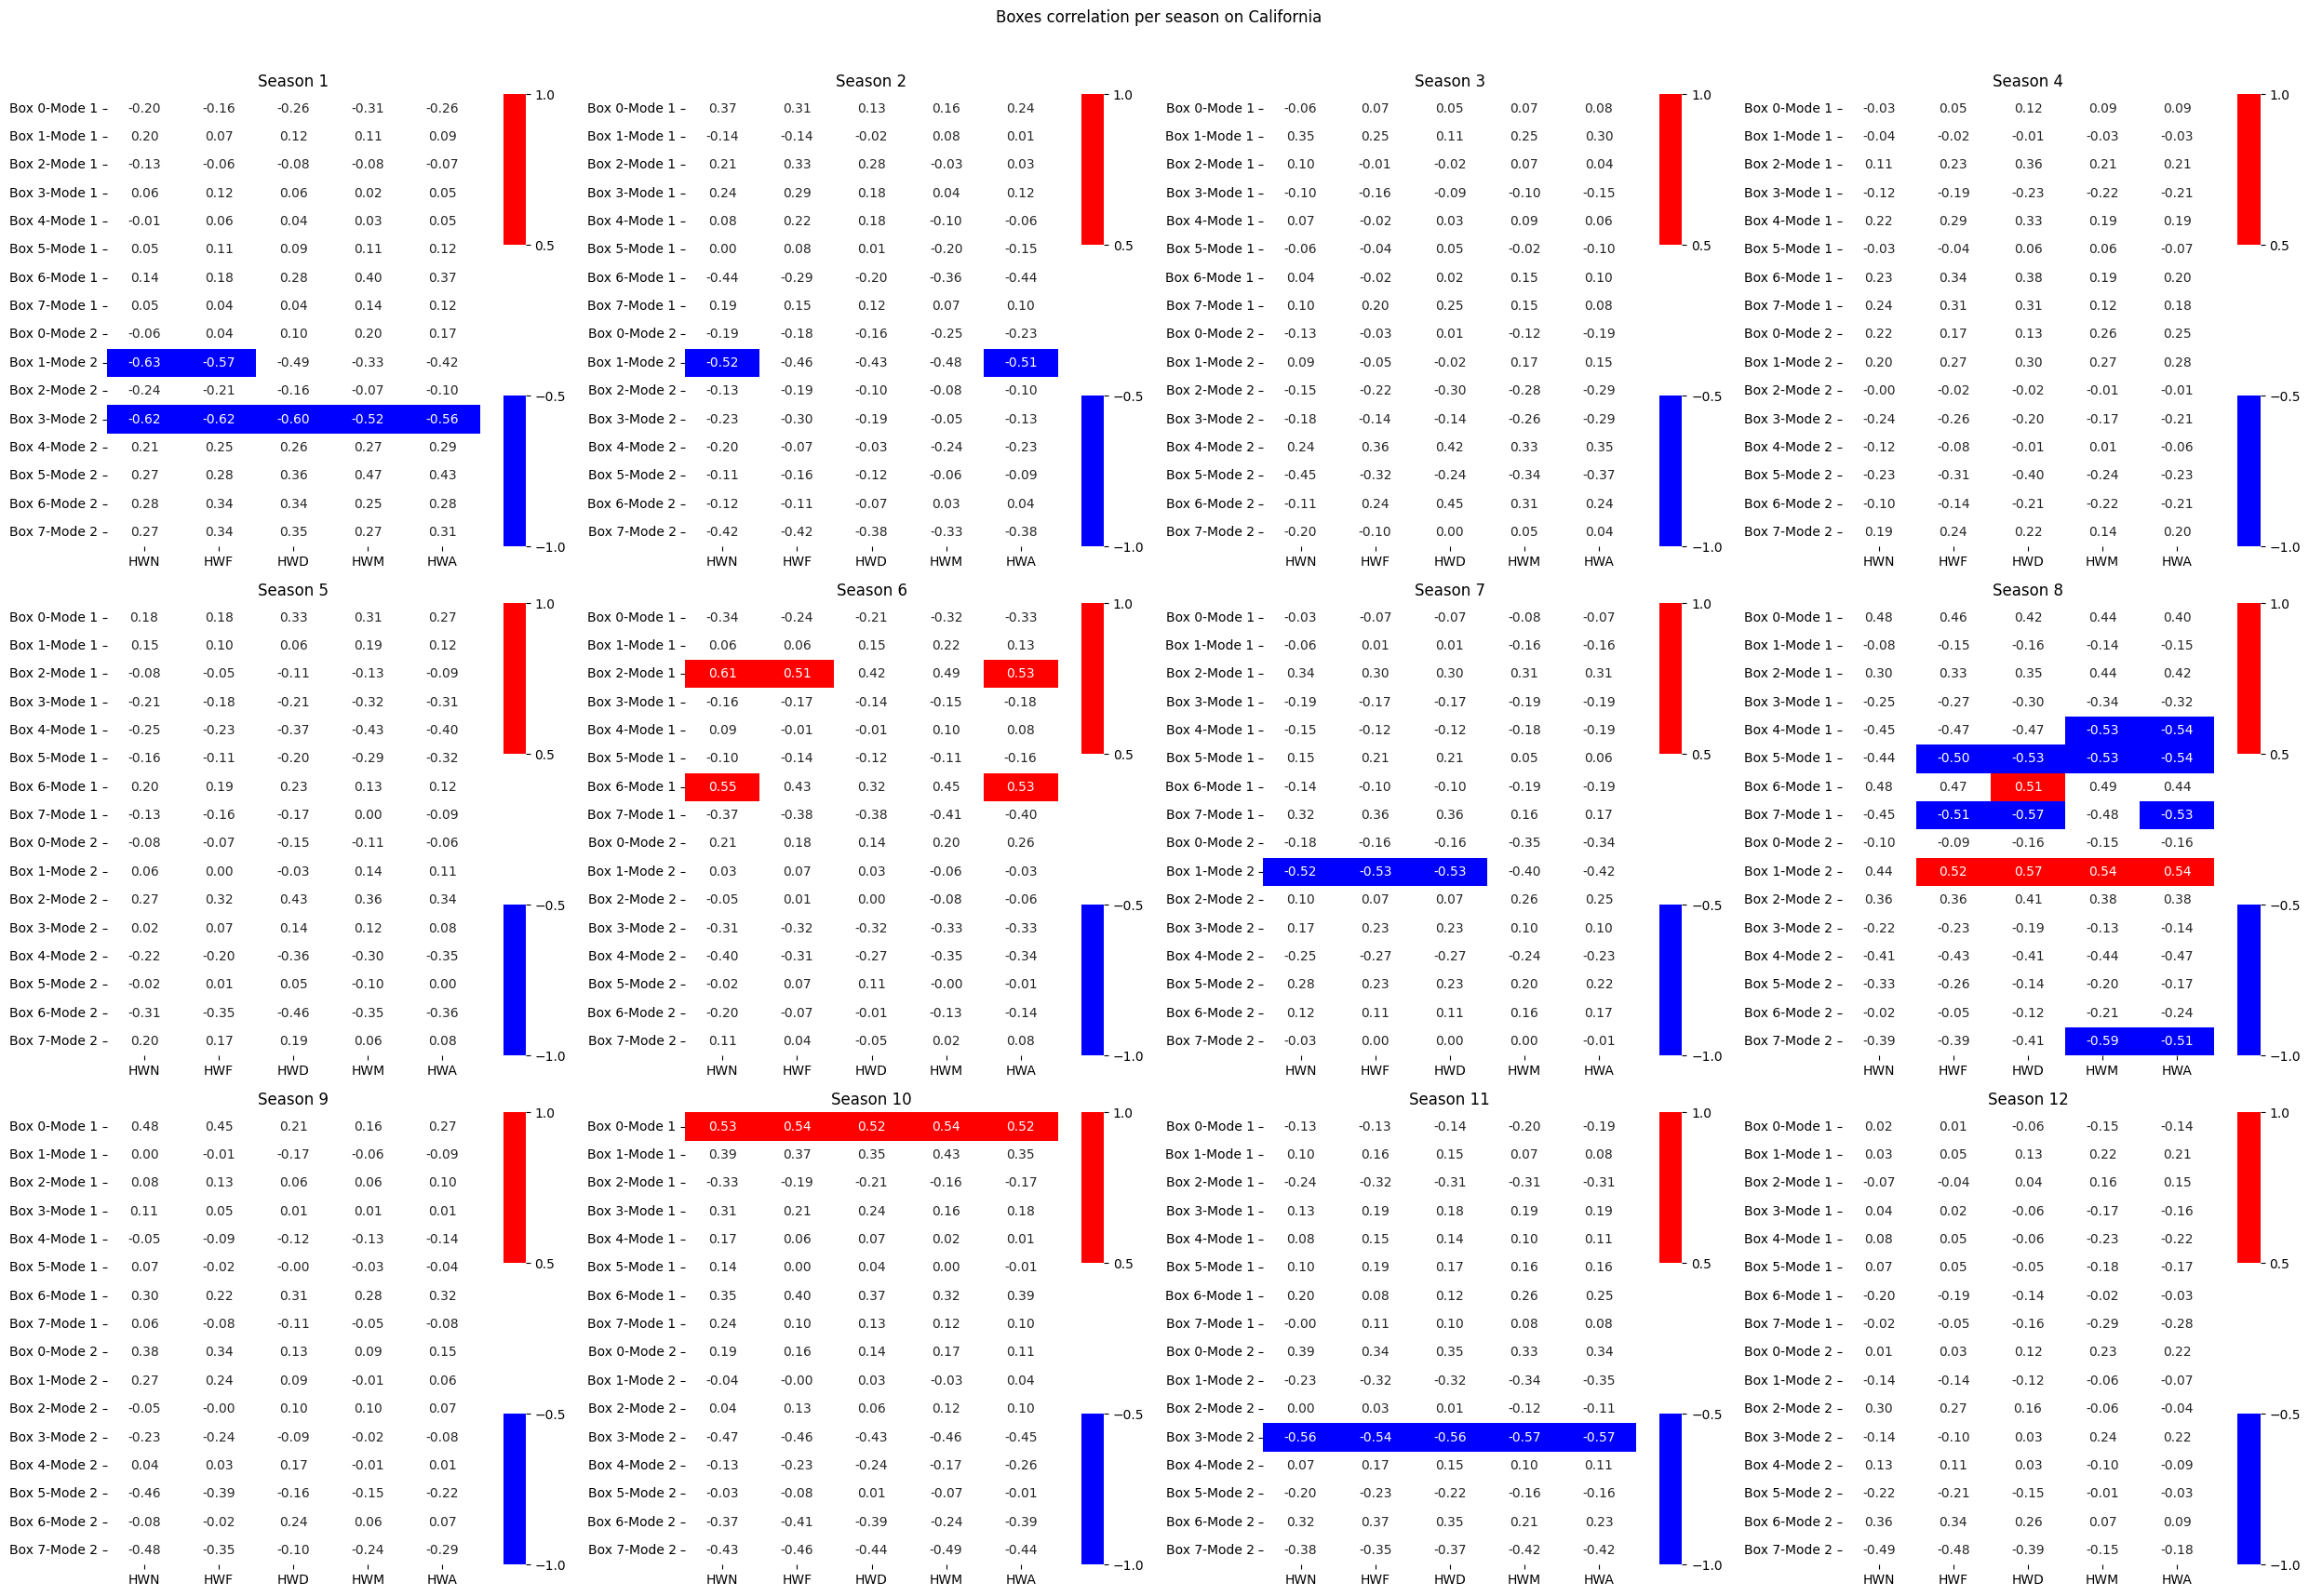

In [ ]:
fig, axs = plt.subplots(3,4, figsize=(25,18))

hwis = hwis[(hwis.index.year <= 2022) & (hwis.index.year >= 2000)]
for i in range(12):
    hwis_month = hwis[hwis.index.month==i+1]
    for num, pca in grid_pca.items():
        hwis_month.loc[:, f"Box {num}-Mode 1"] = pca.get_index_by_season(i+1, 1, start_year=2000)
    sns.heatmap(hwis_month.corr()[["HWN", "HWF", "HWD", "HWM", "HWA"]][5:], annot=True, fmt=".2f", cmap=cmap, norm=norm, ax=axs.flatten()[i], vmax=1, vmin=-1)
    axs.flatten()[i].set_title(f"Season {i+1}")
fig.tight_layout(rect=[0, 0.03, 1, 0.95])  # otherwise the right y-label is slightly clipped
fig.suptitle(f"Boxes linear correlation per season on Brentwood")
plt.show()

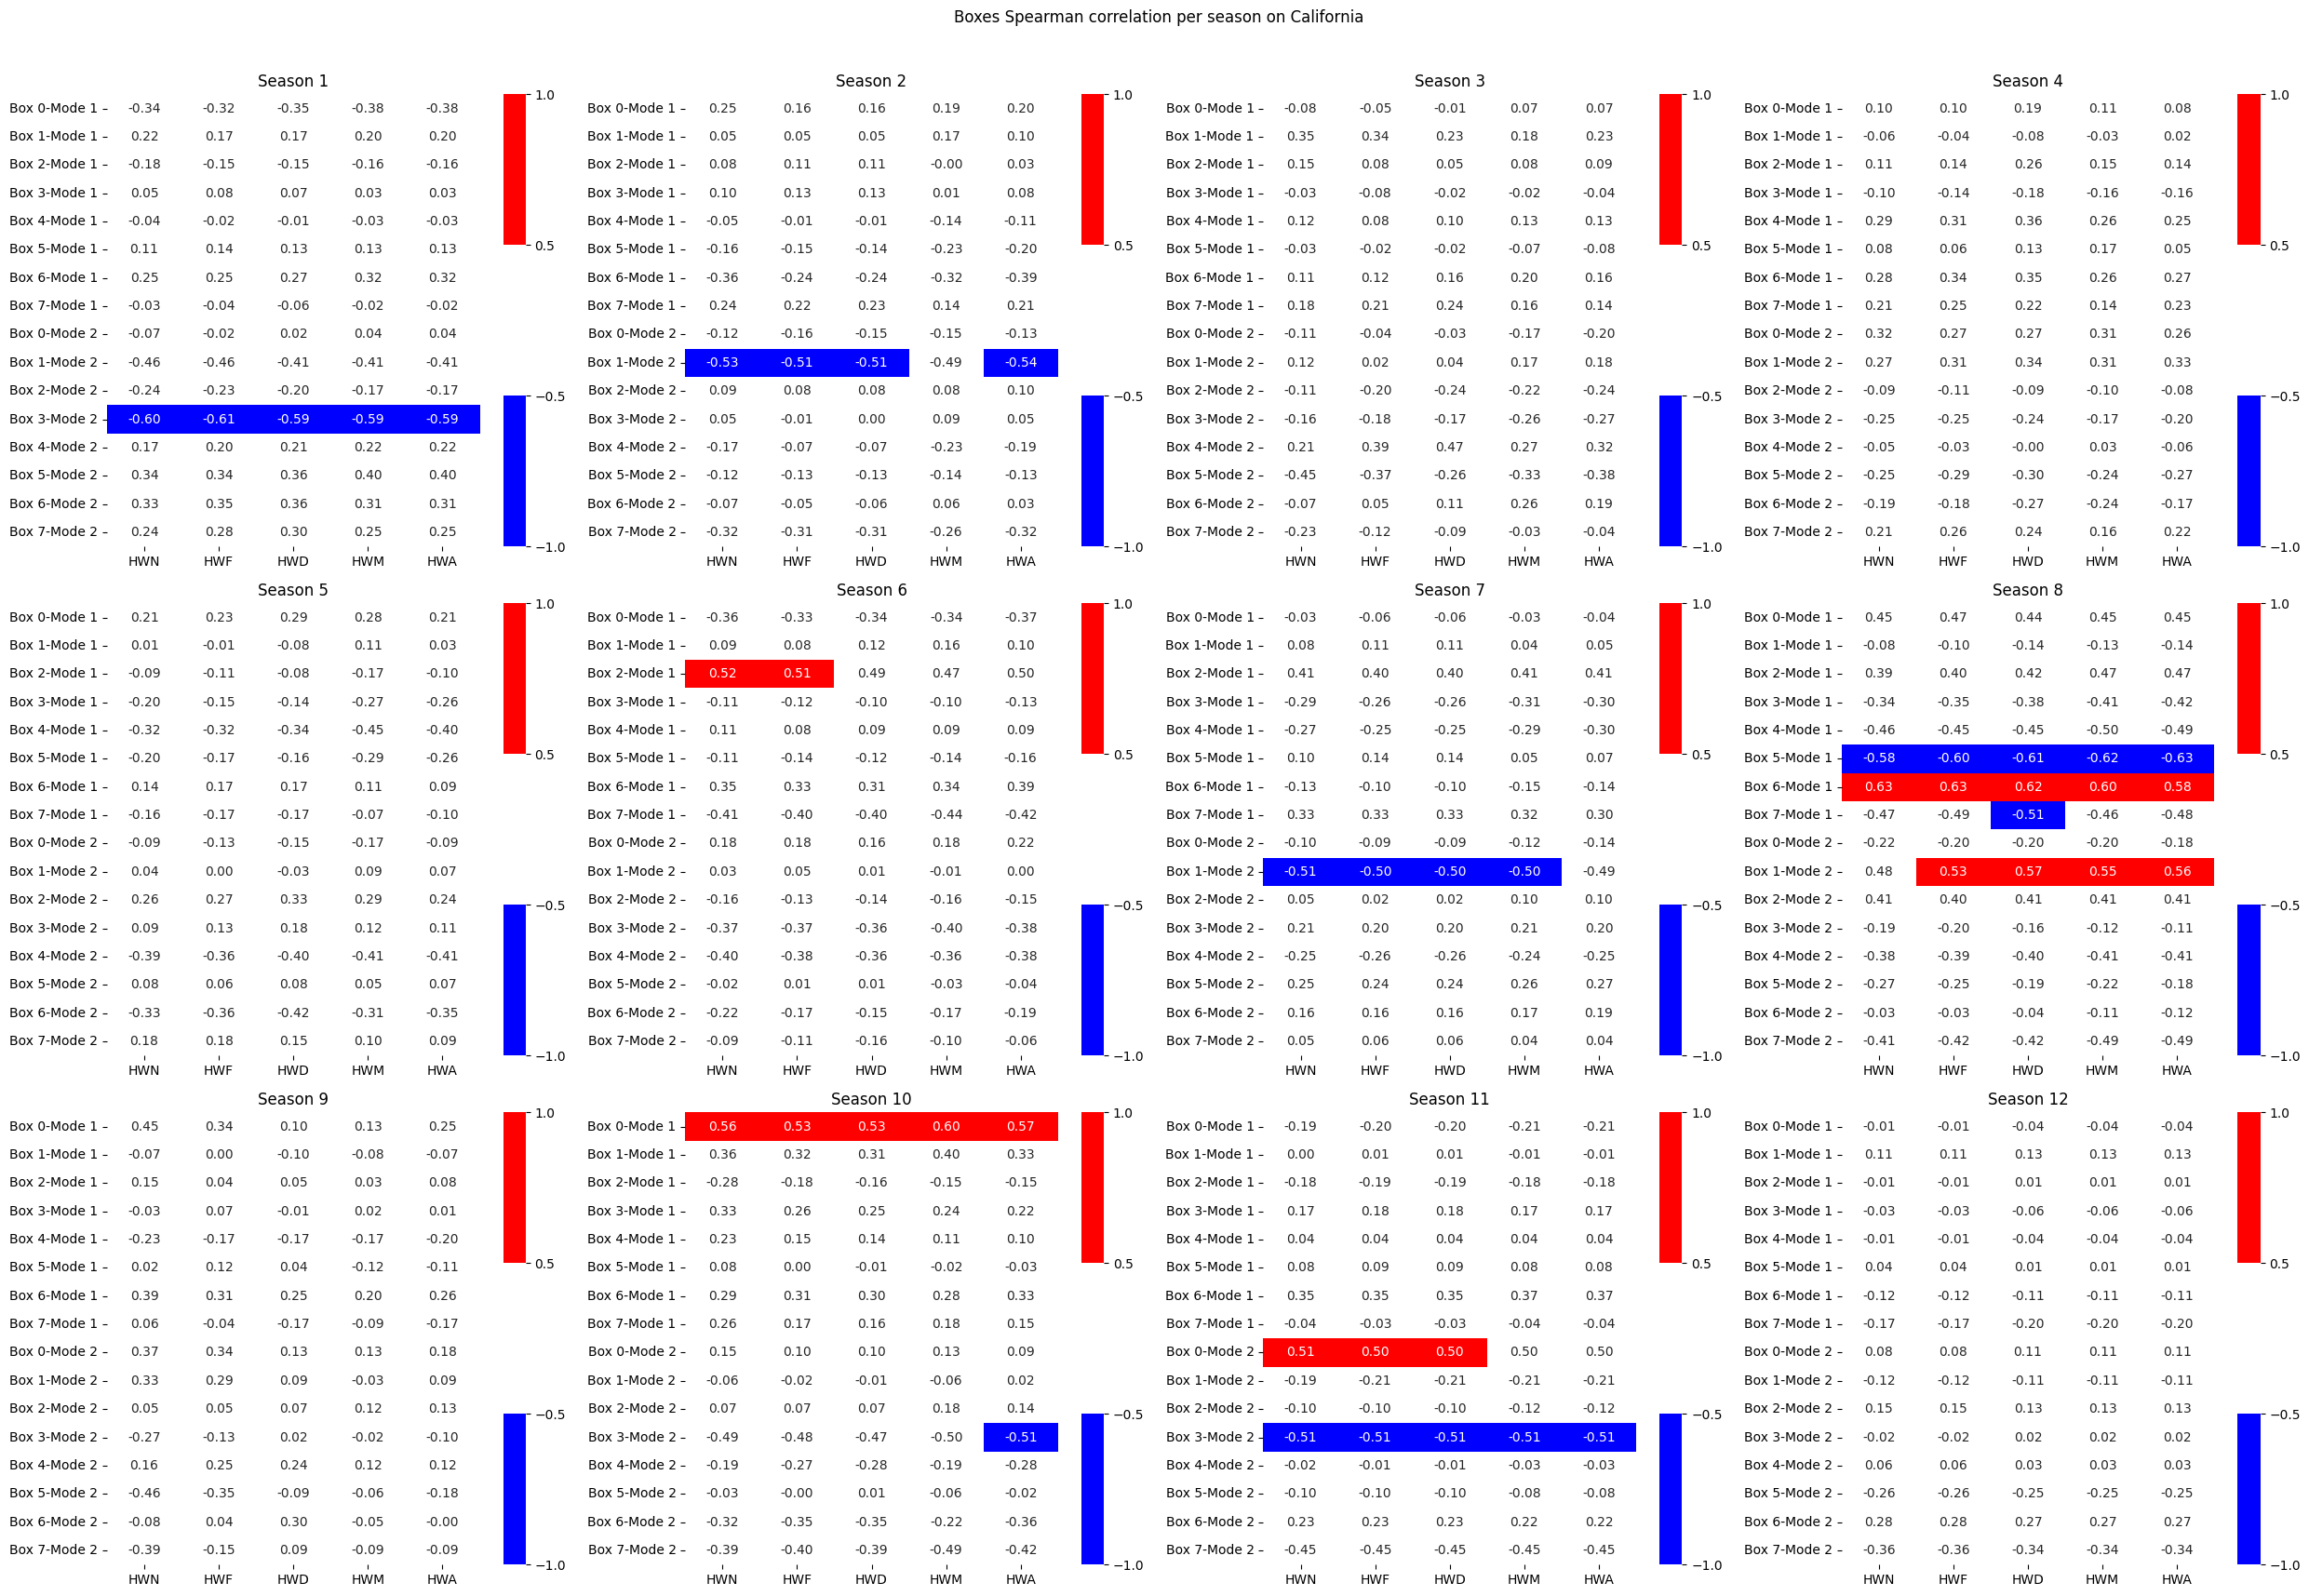

In [ ]:
fig, axs = plt.subplots(3,4, figsize=(25,18))

hwis = hwis[(hwis.index.year <= 2022) & (hwis.index.year >= 2000)]
for i in range(12):
    hwis_month = hwis[hwis.index.month==i+1]
    for num, pca in grid_pca.items():
        hwis_month.loc[:, f"Box {num}-Mode 1"] = pca.get_index_by_season(i+1, 1, start_year=2000)
    sns.heatmap(hwis_month.corr(method='spearman')[["HWN", "HWF", "HWD", "HWM", "HWA"]][5:], annot=True, fmt=".2f", cmap=cmap, norm=norm, ax=axs.flatten()[i], vmax=1, vmin=-1)
    axs.flatten()[i].set_title(f"Season {i+1}")
fig.tight_layout(rect=[0, 0.03, 1, 0.95])  # otherwise the right y-label is slightly clipped
fig.suptitle(f"Boxes Spearman correlation per season on Brentwood")
plt.show()

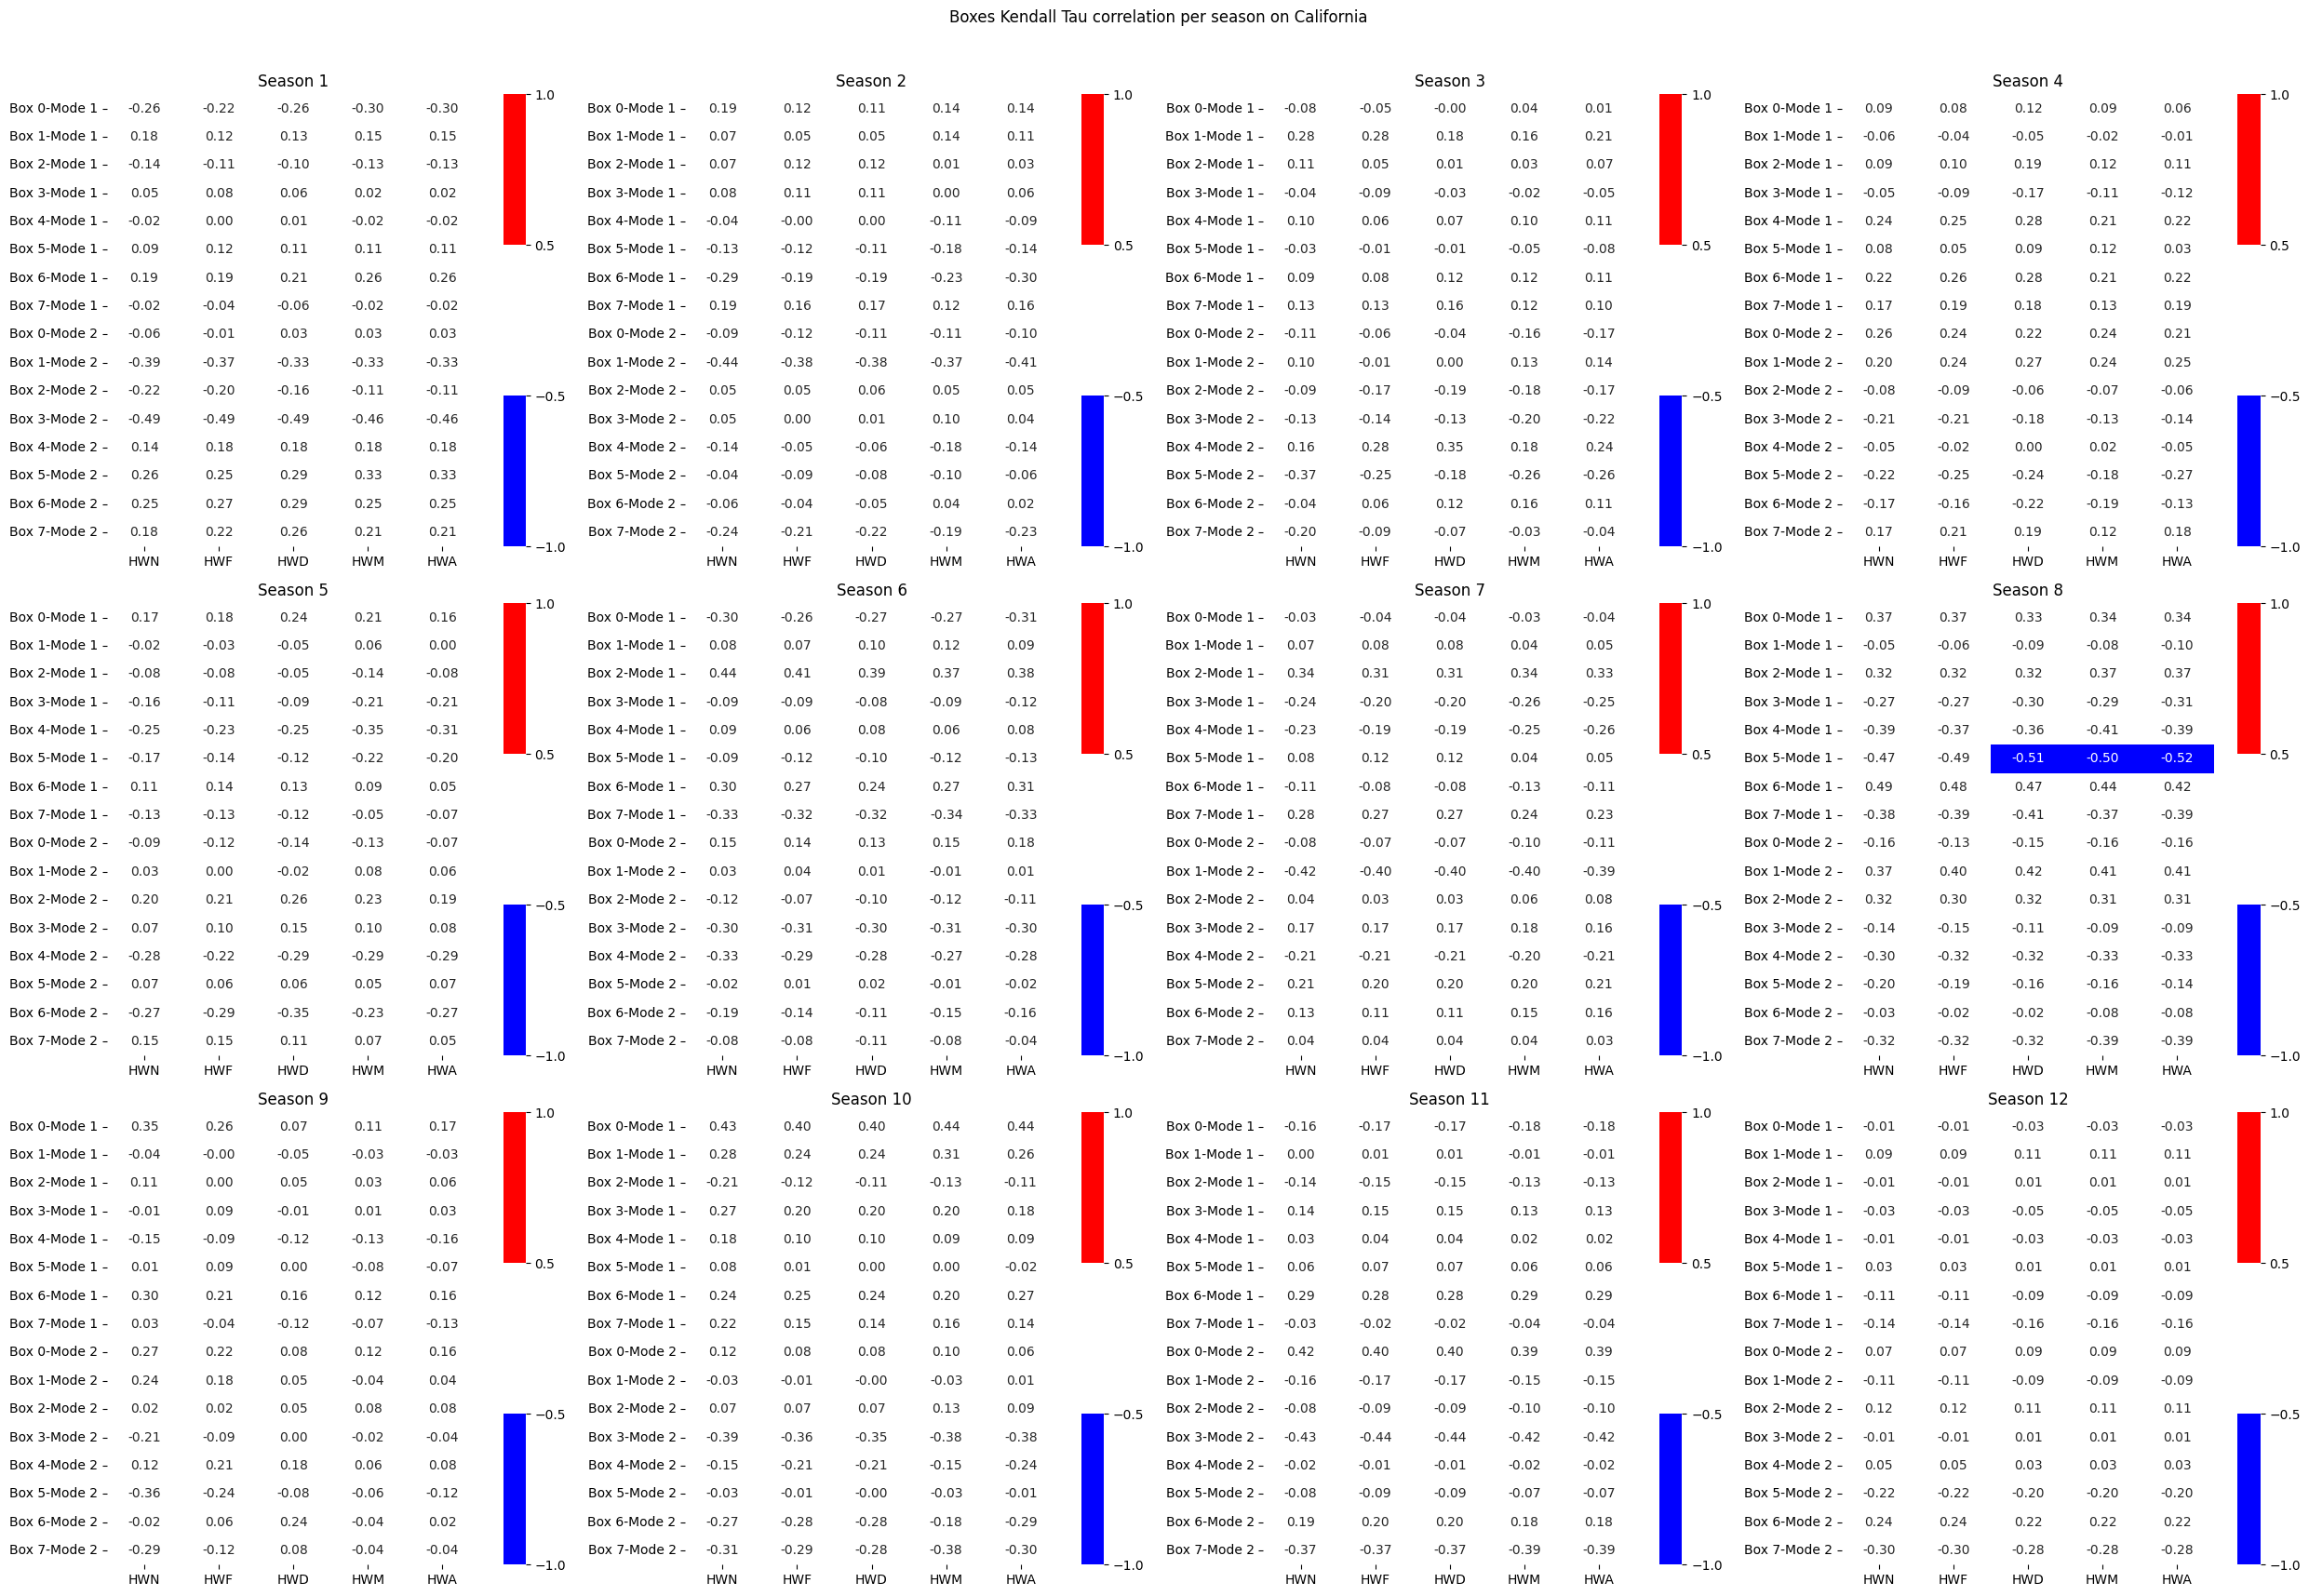

In [ ]:
fig, axs = plt.subplots(3,4, figsize=(25,18))

hwis = hwis[(hwis.index.year <= 2022) & (hwis.index.year >= 2000)]
for i in range(12):
    hwis_month = hwis[hwis.index.month==i+1]
    for num, pca in grid_pca.items():
        hwis_month.loc[:, f"Box {num}-Mode 1"] = pca.get_index_by_season(i+1, 1, start_year=2000)
    sns.heatmap(hwis_month.corr(method='kendall')[["HWN", "HWF", "HWD", "HWM", "HWA"]][5:], annot=True, fmt=".2f", cmap=cmap, norm=norm, ax=axs.flatten()[i], vmax=1, vmin=-1)
    axs.flatten()[i].set_title(f"Season {i+1}")
fig.tight_layout(rect=[0, 0.03, 1, 0.95])  # otherwise the right y-label is slightly clipped
fig.suptitle(f"Boxes Kendall Tau correlation per season on Brentwood")
plt.show()

A good question is about shifted correlation. As we want to predict the HW indices based on past data, let's check the 1-season shifted correlation:

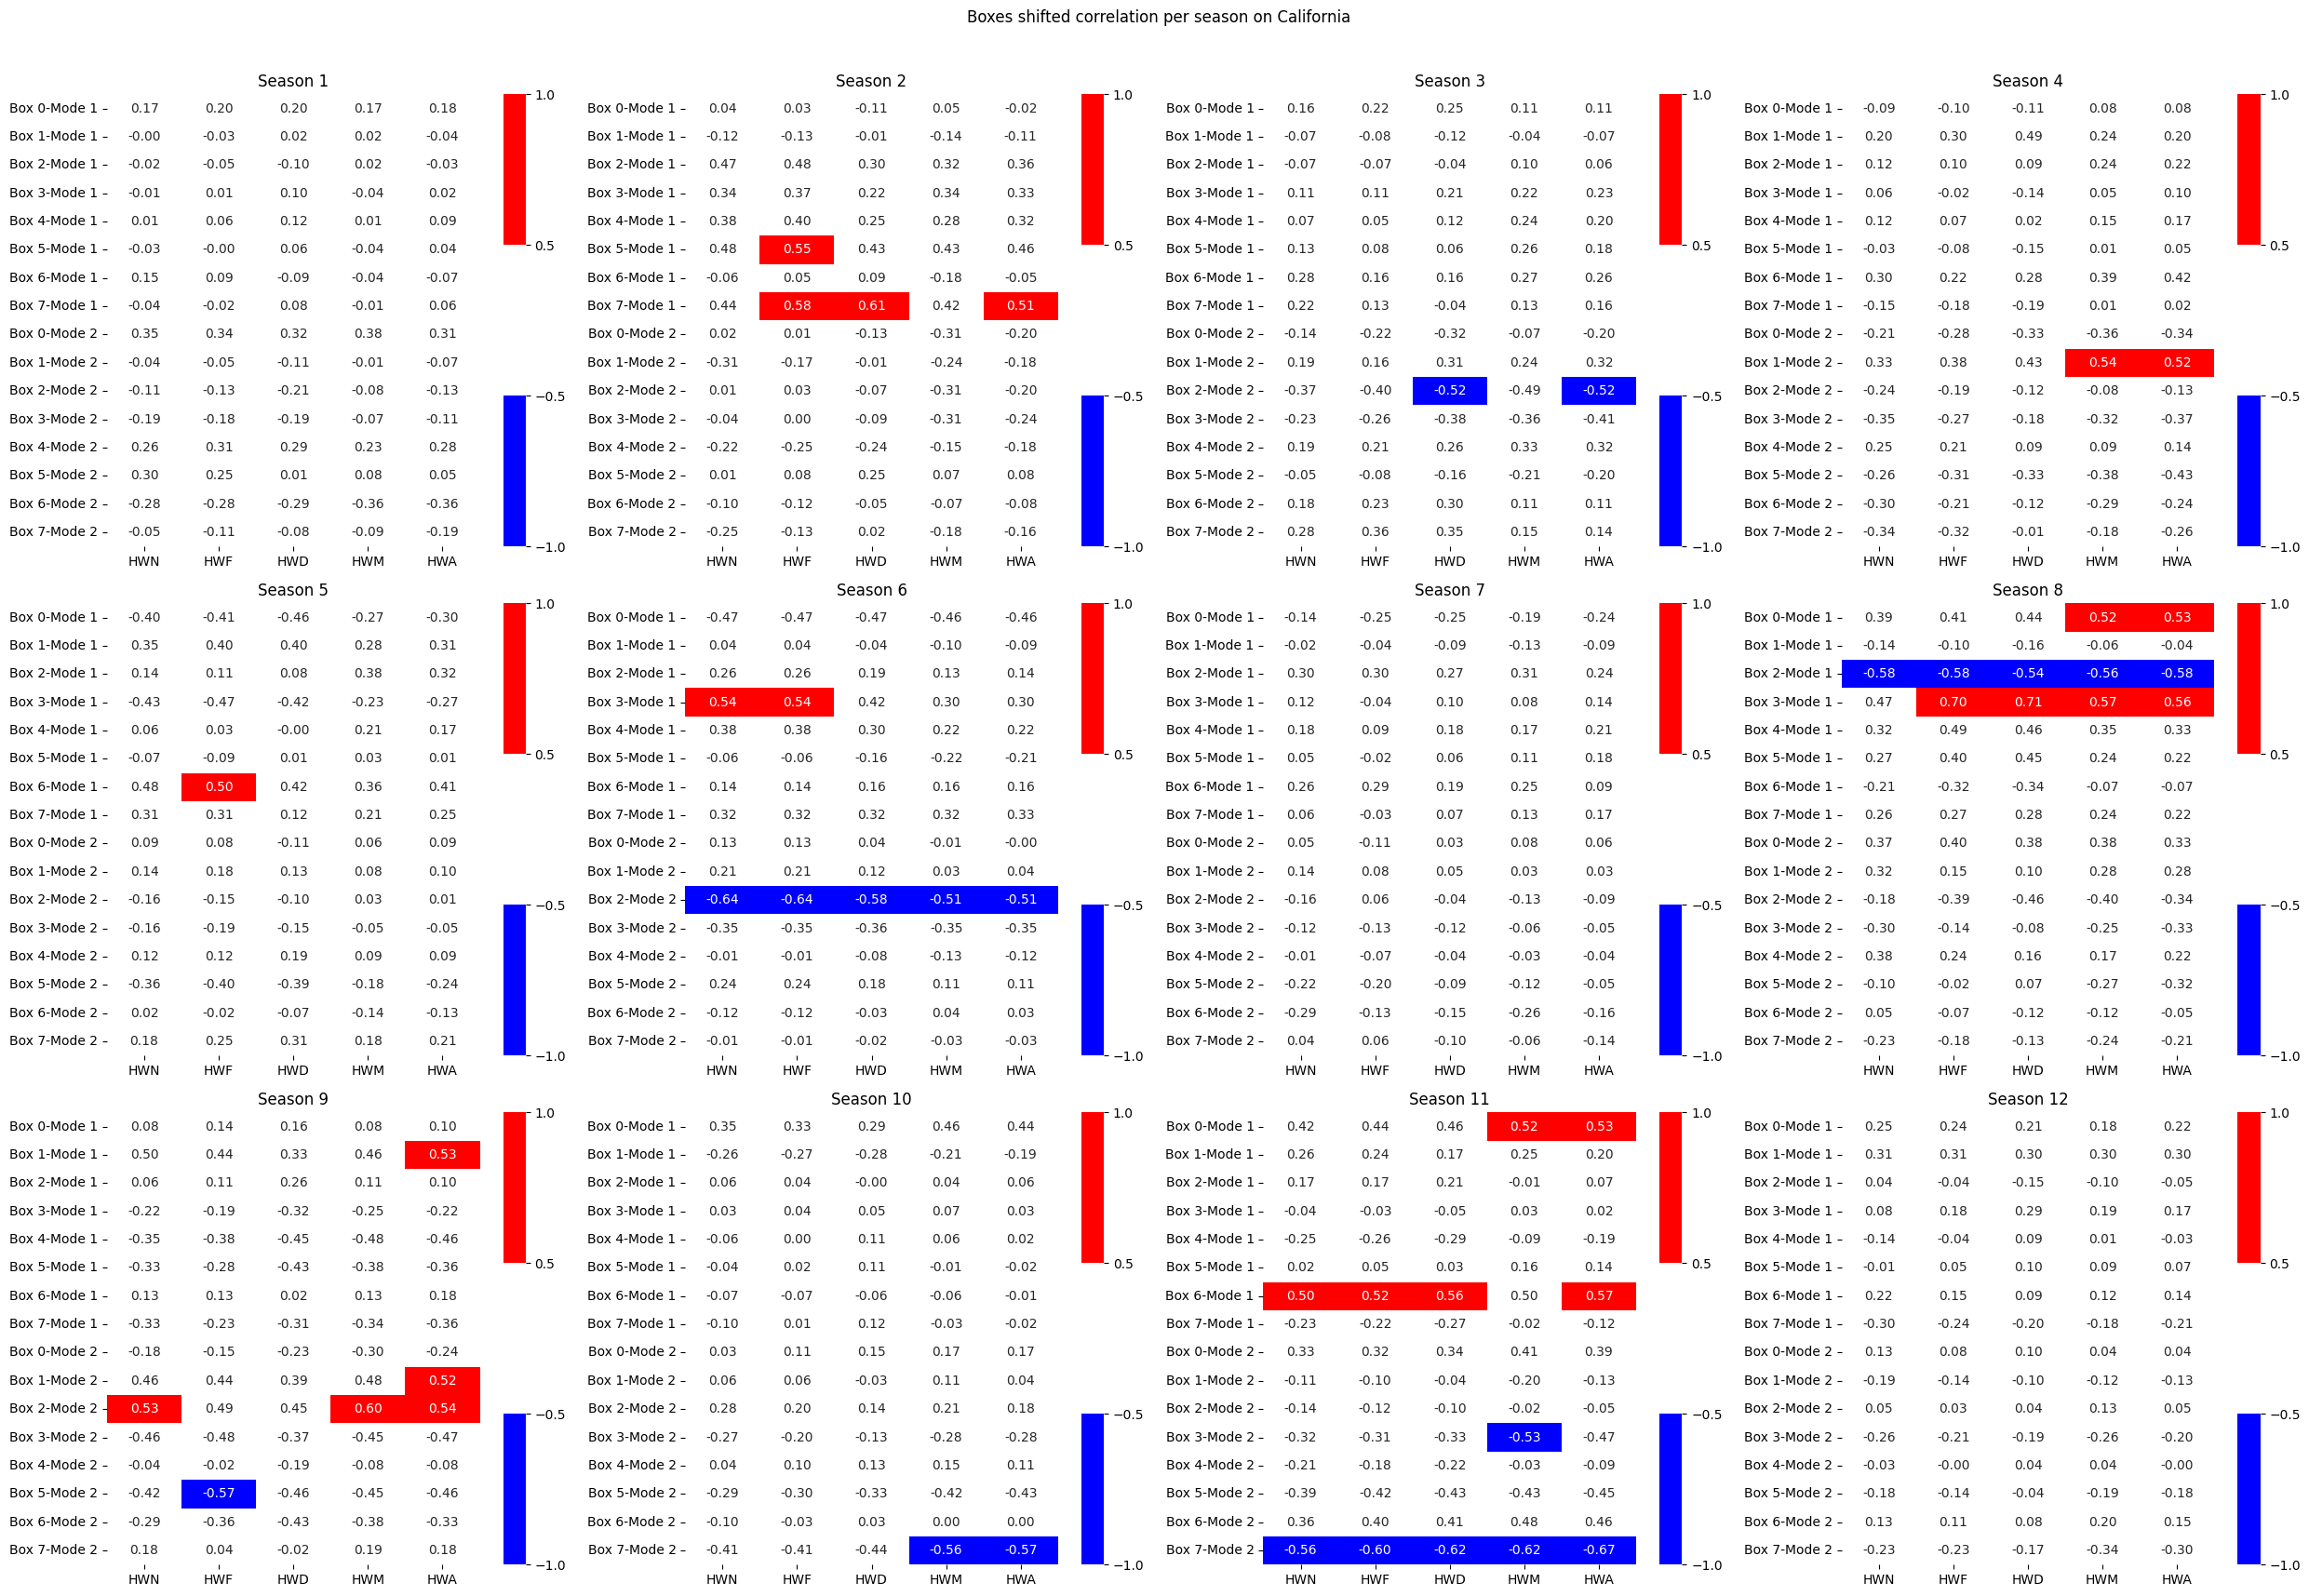

In [ ]:
fig, axs = plt.subplots(3,4, figsize=(25,18))

hwis = hwis[(hwis.index.year <= 2022) & (hwis.index.year >= 2000)]
for i in range(12):
    hwis_month = hwis[hwis.index.month==i+1]
    for num, pca in grid_pca.items():
        if i!= 0:
            hwis_month.loc[:, f"Box {num}-Mode 1"] = pca.get_index_by_season(i, 1, start_year=2000)
        else:
            hwis_month.loc[:, f"Box {num}-Mode 1"] = pca.get_index_by_season(12, 1, start_year=2000)
    sns.heatmap(hwis_month.corr()[["HWN", "HWF", "HWD", "HWM", "HWA"]][5:], annot=True, fmt=".2f", cmap=cmap, norm=norm, ax=axs.flatten()[i], vmax=1, vmin=-1)
    axs.flatten()[i].set_title(f"Season {i+1}")
fig.tight_layout(rect=[0, 0.03, 1, 0.95])  # otherwise the right y-label is slightly clipped
fig.suptitle(f"Boxes shifted correlation per season on Brentwood")
plt.show()